In [ ]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,List,Annotated
from pydantic import BaseModel,Field
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
model= ChatGroq(
model="llama-3.3-70b-versatile",
temperature=0.5
)

In [18]:
class EvaluationSchema(BaseModel):
    feedback:str =Field(description="A detailed feedback on the paragraph")
    score:int =Field(description="A score from 1 to 10",gt=0,le=10)

In [24]:
structured_model=model.with_structured_output(EvaluationSchema)

In [45]:
import operator
class EssayEvalState(TypedDict):
    paragraphs:str
    writing_style:str
    language:str
    overall:str
    individual_score:Annotated[list[int],operator.add] # keep adding the scores of different parameters into individual variable 
    avg_score:float


def evaluate_writing(state:EssayEvalState):
    prompt=f"Evaluate the writing quality of the following essay and provide feedback and assign a score \n {state['paragraphs']}"
    output=structured_model.invoke(prompt)

    return {"writing_style":output.feedback,"individual_score":[output.score]}


def evaluate_language(state:EssayEvalState):
    prompt=f"Evaluate the language quality of the following essay and provide feedback and assign a score \n {state['paragraphs']}"
    output=structured_model.invoke(prompt)

    return {"language":output.feedback,"individual_score":[output.score]}

def overall_evaluate(state:EssayEvalState):
    prompt=f"Based on the following 2 feedbacks, write a summarized feedback \n language_feedback:{state['language']}\n writing_feedback:{state['writing_style']}"
    overall_result=model.invoke(prompt).content # we are using regular model here, not structured output

    avg_score=sum(state['individual_score'])/len(state['individual_score']+[1])# to avoid division by zero

    return {"overall":overall_result,"avg_score":avg_score}

In [46]:
graph=StateGraph(EssayEvalState)

graph.add_node("evaluate_writing",evaluate_writing)
graph.add_node("evaluate_language",evaluate_language)
graph.add_node("overall_evaluate",overall_evaluate)


graph.add_edge(START,"evaluate_writing")
graph.add_edge(START,"evaluate_language")

graph.add_edge("evaluate_writing","overall_evaluate")
graph.add_edge("evaluate_language","overall_evaluate")

graph.add_edge("overall_evaluate",END)

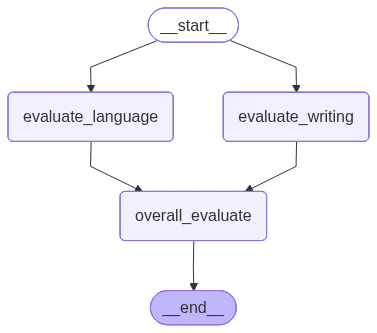

In [47]:
workflow=graph.compile()
workflow

In [48]:
paragraph="""The quiet morning air carried a hint of fresh rain as the sun slowly began to rise, casting a golden glow across the landscape. Birds chirped in the trees, welcoming the new day with their cheerful songs. It was one of those moments where everything seemed to stand still—time paused just long enough to appreciate the simple beauty of the world around us. The earth, still damp from the previous night’s rain, had a fresh scent that filled the air, and for a brief moment, all felt right."""


In [49]:
initial_state={
    "paragraphs":paragraph
}

workflow.invoke(initial_state)

{'paragraphs': 'The quiet morning air carried a hint of fresh rain as the sun slowly began to rise, casting a golden glow across the landscape. Birds chirped in the trees, welcoming the new day with their cheerful songs. It was one of those moments where everything seemed to stand still—time paused just long enough to appreciate the simple beauty of the world around us. The earth, still damp from the previous night’s rain, had a fresh scent that filled the air, and for a brief moment, all felt right.',
 'writing_style': "The essay has a serene and peaceful tone, effectively using sensory details to describe the scene. The use of phrases such as 'hint of fresh rain', 'golden glow', and 'fresh scent' creates a vivid image in the reader's mind. The writing is descriptive and engaging, making the reader feel like they are experiencing the moment alongside the author. However, the essay is quite short and lacks a clear structure or deeper meaning. The author could explore the significance o